In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from persist.persist import PersistentDAG

from persist.persist import PersistentDAG
from functools import wraps

# global variable to simulate the fact to have serialize data somewhere
global IS_COMPUTED
IS_COMPUTED = dict()

from time import sleep
def load_data(*args, **kwargs):
    sleep(2)
    print 'load data ...'
    if args:
        print args
        return 'data_{}'.format(args)
    if kwargs:
        print kwargs
        return 'data_{}'.format(kwargs)
    return 'data'


def clean_data(data, *args, **kwargs):
    assert isinstance(data, str)
    print 'clean data ...'
    if args:
        print args
        data = data + '_' + '_'.join(map(lambda x: '{}'.format(x), args))
    if kwargs:
        print kwargs
        data = data + '_' + \
            '_'.join(map(lambda kv: '{}_{}'.format(
                kv[0], kv[1]), kwargs.items()))
    return 'cleaned_{}'.format(data)


def analyze_data(cleaned_data, option=1, **other_options):
    assert isinstance(cleaned_data, str)
    print 'analyze data ...'
    return 'analyzed_{}'.format(cleaned_data)



class Serializer(object):

    def __init__(self):
        pass

    def load(self, key):
        print "load data for key {} ...".format(key)
        return IS_COMPUTED[key]

    def dump(self, key, value):
        print "save data with key {} ...".format(key)
        IS_COMPUTED[key] = value

    def is_computed(self, key):
        global IS_COMPUTED
        return IS_COMPUTED.get(key) is not None

    def delayed_load(self, key):
        def load():
            return self.load(key)
        return load

    def dump_result(self, func, key):
        @wraps(func)
        def wrapped_func(*args, **kwargs):
            result = func(*args, **kwargs)
            self.dump(key, result)
            return result
        return wrapped_func

In [3]:
def setup_graph():
    g = PersistentDAG()
    serializer = Serializer()
    g.add_task(load_data, option=10,
               dask_key_name='key_data1', 
               dask_serializer=serializer 
              )
    g.add_task(load_data, option=20,
               dask_key_name='key_data2', 
               dask_serializer=serializer
              )

    kwargs = dict(data='key_data1', other='key_data2')
    g.add_task(clean_data,
               dask_key_name='cleaned_data', 
               #dask_serializer=serializer,
               **kwargs)
    g.add_task(analyze_data, 'cleaned_data',
               # dask_key_name='analyzed_data', 
              dask_serializer=serializer)
    return g

In [4]:
g = setup_graph()

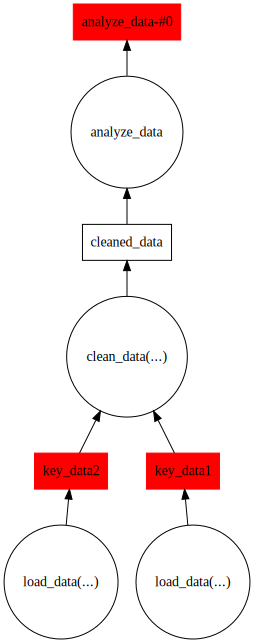

In [5]:
g.visualize(format='svg')

In [6]:
g.dask

{'analyze_data-d751297ccc2e5332fd707c4df502e736': (<function __main__.analyze_data>,
  'cleaned_data'),
 'cleaned_data': (<function apply>,
  <function __main__.clean_data>,
  [],
  (dict, [['other', 'key_data2'], ['data', 'key_data1']])),
 'key_data1': (<function apply>,
  <function __main__.load_data>,
  [],
  (dict, [['option', 10]])),
 'key_data2': (<function apply>,
  <function __main__.load_data>,
  [],
  (dict, [['option', 20]]))}

In [7]:
IS_COMPUTED

{}

In [8]:
g.compute()

load data ...
{'option': 10}
save data with key key_data1 ...
load data ...
{'option': 20}
save data with key key_data2 ...
clean data ...
{'other': "data_{'option': 20}"}
analyze data ...
save data with key analyze_data-d751297ccc2e5332fd707c4df502e736 ...


["analyzed_cleaned_data_{'option': 10}_other_data_{'option': 20}"]

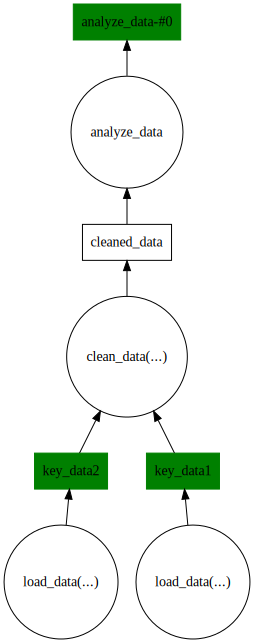

In [9]:
g.visualize(format='svg')

In [10]:
g.dask

{'analyze_data-d751297ccc2e5332fd707c4df502e736': (<function __main__.load>,),
 'cleaned_data': (<function apply>,
  <function __main__.clean_data>,
  [],
  (dict, [['other', 'key_data2'], ['data', 'key_data1']])),
 'key_data1': (<function __main__.load>,),
 'key_data2': (<function __main__.load>,)}

In [11]:
IS_COMPUTED

{'analyze_data-d751297ccc2e5332fd707c4df502e736': "analyzed_cleaned_data_{'option': 10}_other_data_{'option': 20}",
 'key_data1': "data_{'option': 10}",
 'key_data2': "data_{'option': 20}"}

In [12]:
g.compute()

load data for key key_data1 ...
load data for key key_data2 ...
load data for key analyze_data-d751297ccc2e5332fd707c4df502e736 ...
clean data ...
{'other': "data_{'option': 20}"}


["cleaned_data_{'option': 10}_other_data_{'option': 20}",
 "analyzed_cleaned_data_{'option': 10}_other_data_{'option': 20}"]

If we instantiate another graph, it automatically detect that some data has already been computed.

In [13]:
g = setup_graph()

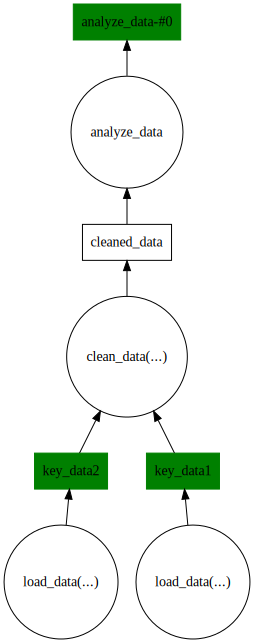

In [14]:
g.visualize(format='svg')

We can visualize the graph with methods replaced by load methods on disk.

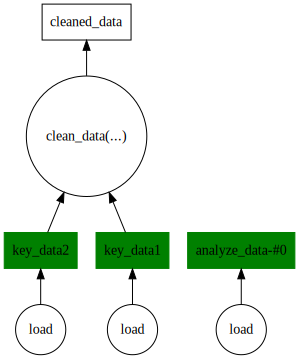

In [15]:
g.visualize(format='svg', raw_dask=False)

## Persist method 

In [16]:
g.clean()

AttributeError: 'PersistentDAG' object has no attribute 'clean'

In [ ]:
data = g.persist()

In [ ]:
data

In [ ]:
g.run()

In [ ]:
data.compute()

In [ ]:
IS_COMPUTED

In [ ]:
g.visualize(format='svg')

In [ ]:
data = g.submit(analyze_data, 'cleaned_data')
data.compute()

In [ ]:
import dask
with dask.set_options(get=dask.async.get_sync):
    g.run()

In [ ]:
IS_COMPUTED

In [ ]:
%pylab inline

In [ ]:
graph = g.to_digraph()
import networkx as nx
nx.draw(graph)

In [ ]:
from distributed import Client
client = Client()
global IS_COMPUTED
IS_COMPUTED = {}

In [ ]:
g.persist()

In [ ]:
g.compute()

In [ ]:
g.visualize(format='svg')

In [ ]:
# TODO: we have to use a real serializer in order to make things work with futures.